In [1]:
# %matplotlib widget

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data_io import read_iq_data
from visualisation import PDRPlotter
from receiver import ReceiverBLE, Receiver802154, Receiver
from filters import add_awgn_band_limited

In [ ]:
from demodulation import TEDType
from receiver import DemodulationType, ReceiverType


# Computes the packet delivery rate (PDR) and its standard deviation over a range of AWGN SNR values
def pdr_vs_snr_analysis(
    iq_samples: np.ndarray,
    snr_range: range,
    bw_snr: float,
    fs: float,
    receiver_type: str,
    demodulation_type: DemodulationType,
    ted_type: TEDType,
    noise_realisations: int,
) -> dict:
    """
    Computes the packet delivery rate (PDR) and its standard deviation over a range of AWGN SNR values.

    A packet is considered delivered if the decoded packet passes the CRC check.
    It is considered lost if:
      - The receiver fails to detect the preamble.
      - The CRC check fails.
    """

    receiver_classes: dict[str, type[Receiver]] = {"BLE": ReceiverBLE, "IEEE802154": Receiver802154}
    try:
        receiver = receiver_classes[receiver_type](fs)
    except KeyError:
        raise ValueError(f"Invalid receiver type '{receiver_type}'. Choose from {list(receiver_classes.keys())}")

    results: dict = {}

    for snr in snr_range:
        delivered_count: int = 0
        preamble_loss_count: int = 0
        crc_failure_count: int = 0

        for _ in range(noise_realisations):
            iq_noisy = add_awgn_band_limited(iq_samples, snr_db=snr, fs=fs, bw=bw_snr)

            try:
                received_packets: list[dict] = receiver.demodulate_to_packet(
                    iq_noisy, demodulation_type=demodulation_type, ted_type=ted_type
                )
            except ValueError as e:
                if "The binary list" in str(e):
                    preamble_loss_count += 1
                    continue
                else:
                    raise

            if not received_packets:
                preamble_loss_count += 1
            elif not received_packets[0]["crc_check"]:
                crc_failure_count += 1
            else:
                delivered_count += 1

        results[snr] = {
            "pdr_ratio": delivered_count / noise_realisations,
            "preamble_loss_ratio": preamble_loss_count / noise_realisations,
            "crc_failure_ratio": crc_failure_count / noise_realisations,
        }  # preamble_loss_ratio + crc_failure_ratio + pdr_ratio = 1

    return results

In [ ]:
import concurrent.futures
import numpy as np


def process_noise_realisation(
    iq_samples: np.ndarray,
    snr: float,
    fs: float,
    bw_snr: float,
    receiver: Receiver,
    demodulation_type: DemodulationType,
    ted_type: TEDType,
):
    """Process one noise realisation: adds noise, demodulates, and categorises the packet result."""
    iq_noisy = add_awgn_band_limited(iq_samples, snr_db=snr, fs=fs, bw=bw_snr)

    try:
        received_packets = receiver.demodulate_to_packet(
            iq_noisy, demodulation_type=demodulation_type, ted_type=ted_type
        )
    except ValueError as e:
        if "The binary list" in str(e):
            return "preamble_loss"
        else:
            raise

    if not received_packets:
        return "preamble_loss"
    elif not received_packets[0]["crc_check"]:
        return "crc_failure"
    else:
        return "delivered"


def pdr_vs_snr_analysis_parallel(
    iq_samples: np.ndarray,
    snr_range: range,
    bw_snr: float,
    fs: float,
    receiver_type: str,
    demodulation_type: str,
    ted_type: str,
    noise_realisations: int,
) -> dict:
    """Computes the PDR and its standard deviation over a range of SNR values using parallel processing."""
    receiver_classes: dict[str, type] = {"BLE": ReceiverBLE, "IEEE802154": Receiver802154}
    try:
        # Create a new receiver for each SNR value in the worker below
        receiver_factory = receiver_classes[receiver_type]
    except KeyError:
        raise ValueError(f"Invalid receiver type '{receiver_type}'. Choose from {list(receiver_classes.keys())}")

    results: dict = {}

    for snr in snr_range:
        receiver = receiver_factory(fs)
        delivered_count = 0
        preamble_loss_count = 0
        crc_failure_count = 0

        # Use ProcessPoolExecutor for CPU-bound tasks
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    process_noise_realisation,
                    iq_samples,
                    snr,
                    fs,
                    bw_snr,
                    receiver,
                    demodulation_type,
                    ted_type,
                )
                for _ in range(noise_realisations)
            ]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                if result == "delivered":
                    delivered_count += 1
                elif result == "preamble_loss":
                    preamble_loss_count += 1
                elif result == "crc_failure":
                    crc_failure_count += 1

        results[snr] = {
            "pdr_ratio": delivered_count / noise_realisations,
            "preamble_loss_ratio": preamble_loss_count / noise_realisations,
            "crc_failure_ratio": crc_failure_count / noise_realisations,
        }

    return results

# BLE example

In [4]:
bw_snrs: dict = {"BLE": 1.5e6, "IEEE802154": 3e6}
filenames: dict = {"BLE": "BLE_0dBm.dat", "IEEE802154": "802154_0dBm.dat"}  # Open BLE file

fs = 10e6  # Hz
receiver_type: ReceiverType = "BLE"
iq_samples: np.ndarray = read_iq_data(f"../../capture_nRF/data/new/{filenames[receiver_type]}")
demodulation_type: DemodulationType = "INSTANTANEOUS_FREQUENCY"
ted_type: TEDType = "MOD_MUELLER_AND_MULLER"

snr_range = range(10, 20, 1)
noise_realisations = int(1e4)

pdr: dict = pdr_vs_snr_analysis(
    iq_samples=iq_samples,
    snr_range=snr_range,
    bw_snr=bw_snrs[receiver_type],
    fs=fs,
    receiver_type=receiver_type,
    demodulation_type=demodulation_type,
    ted_type=ted_type,
    noise_realisations=noise_realisations,
)

print(pdr)

{10: {'pdr_ratio': 0.0501, 'preamble_loss_ratio': 0.1593, 'crc_failure_ratio': 0.7906}, 11: {'pdr_ratio': 0.1786, 'preamble_loss_ratio': 0.141, 'crc_failure_ratio': 0.6804}, 12: {'pdr_ratio': 0.3937, 'preamble_loss_ratio': 0.1317, 'crc_failure_ratio': 0.4746}, 13: {'pdr_ratio': 0.5752, 'preamble_loss_ratio': 0.1199, 'crc_failure_ratio': 0.3049}, 14: {'pdr_ratio': 0.6987, 'preamble_loss_ratio': 0.1056, 'crc_failure_ratio': 0.1957}, 15: {'pdr_ratio': 0.7693, 'preamble_loss_ratio': 0.1005, 'crc_failure_ratio': 0.1302}, 16: {'pdr_ratio': 0.8209, 'preamble_loss_ratio': 0.0899, 'crc_failure_ratio': 0.0892}, 17: {'pdr_ratio': 0.8387, 'preamble_loss_ratio': 0.0885, 'crc_failure_ratio': 0.0728}, 18: {'pdr_ratio': 0.8553, 'preamble_loss_ratio': 0.0867, 'crc_failure_ratio': 0.058}, 19: {'pdr_ratio': 0.8625, 'preamble_loss_ratio': 0.0853, 'crc_failure_ratio': 0.0522}}


In [6]:
pdr_parallel: dict = pdr_vs_snr_analysis_parallel(
    iq_samples=iq_samples,
    snr_range=snr_range,
    bw_snr=bw_snrs[receiver_type],
    fs=fs,
    receiver_type=receiver_type,
    demodulation_type=demodulation_type,
    ted_type=ted_type,
    noise_realisations=noise_realisations,
)

print(pdr_parallel)

{10: {'pdr_ratio': 0.0471, 'preamble_loss_ratio': 0.1778, 'crc_failure_ratio': 0.7751}, 11: {'pdr_ratio': 0.1757, 'preamble_loss_ratio': 0.1646, 'crc_failure_ratio': 0.6597}, 12: {'pdr_ratio': 0.3691, 'preamble_loss_ratio': 0.1392, 'crc_failure_ratio': 0.4917}, 13: {'pdr_ratio': 0.5586, 'preamble_loss_ratio': 0.1179, 'crc_failure_ratio': 0.3235}, 14: {'pdr_ratio': 0.6807, 'preamble_loss_ratio': 0.1088, 'crc_failure_ratio': 0.2105}, 15: {'pdr_ratio': 0.7626, 'preamble_loss_ratio': 0.0974, 'crc_failure_ratio': 0.14}, 16: {'pdr_ratio': 0.8085, 'preamble_loss_ratio': 0.0958, 'crc_failure_ratio': 0.0957}, 17: {'pdr_ratio': 0.85, 'preamble_loss_ratio': 0.0784, 'crc_failure_ratio': 0.0716}, 18: {'pdr_ratio': 0.8584, 'preamble_loss_ratio': 0.0792, 'crc_failure_ratio': 0.0624}, 19: {'pdr_ratio': 0.8677, 'preamble_loss_ratio': 0.0808, 'crc_failure_ratio': 0.0515}}


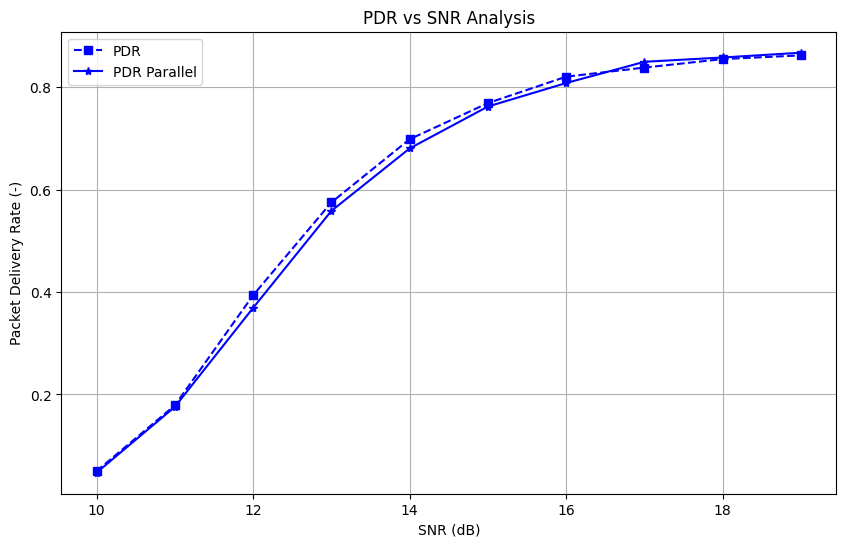

In [7]:
plotter = PDRPlotter()
plotter.add_trace(pdr, "PDR", colour="blue", linestyle="--", marker="s")
plotter.add_trace(pdr_parallel, "PDR Parallel", colour="blue", linestyle="-", marker="*")
plotter.plot(title="PDR vs SNR Analysis")

# IEEE 802.15.4 example 